## Deep face recognition with Keras, Dlib and OpenCV

Face recognition identifies persons on face images or video frames. In a nutshell, a face recognition system extracts features from an input face image and compares them to the features of labeled faces in a database. Comparison is based on a feature similarity metric and the label of the most similar database entry is used to label the input image. If the similarity value is below a certain threshold the input image is labeled as *unknown*. Comparing two face images to determine if they show the same person is known as face verification.

This notebook uses a deep convolutional neural network (CNN) to extract features from input images. It follows the approach described in [[1]](https://arxiv.org/abs/1503.03832) with modifications inspired by the [OpenFace](http://cmusatyalab.github.io/openface/) project. [Keras](https://keras.io/) is used for implementing the CNN, [Dlib](http://dlib.net/) and [OpenCV](https://opencv.org/) for aligning faces on input images. Face recognition performance is evaluated on a small subset of the [LFW](http://vis-www.cs.umass.edu/lfw/) dataset which you can replace with your own custom dataset e.g. with images of your family and friends if you want to further experiment with this notebook. After an overview of the CNN architecure and how the model can be trained, it is demonstrated how to:

- Detect, transform, and crop faces on input images. This ensures that faces are aligned before feeding them into the CNN. This preprocessing step is very important for the performance of the neural network.
- Use the CNN to extract 128-dimensional representations, or *embeddings*, of faces from the aligned input images. In embedding space, Euclidean distance directly corresponds to a measure of face similarity. 
- Compare input embedding vectors to labeled embedding vectors in a database. Here, a support vector machine (SVM) and a KNN classifier, trained on labeled embedding vectors, play the role of a database. Face recognition in this context means using these classifiers to predict the labels i.e. identities of new inputs.

### Environment setup

For running this notebook, create and activate a new [virtual environment](https://docs.python.org/3/tutorial/venv.html) and install the packages listed in [requirements.txt](requirements.txt) with `pip install -r requirements.txt`. Furthermore, you'll need a local copy of Dlib's face landmarks data file for running face alignment:

In [1]:
import bz2
import os

from urllib.request import urlopen

def download_landmarks(dst_file):
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    decompressor = bz2.BZ2Decompressor()
    
    with urlopen(url) as src, open(dst_file, 'wb') as dst:
        data = src.read(1024)
        while len(data) > 0:
            dst.write(decompressor.decompress(data))
            data = src.read(1024)

dst_dir = 'models'
dst_file = os.path.join(dst_dir, 'landmarks.dat')

if not os.path.exists(dst_file):
    os.makedirs(dst_dir)
    download_landmarks(dst_file)

### CNN architecture and training

The CNN architecture used here is a variant of the inception architecture [[2]](https://arxiv.org/abs/1409.4842). More precisely, it is a variant of the NN4 architecture described in [[1]](https://arxiv.org/abs/1503.03832) and identified as [nn4.small2](https://cmusatyalab.github.io/openface/models-and-accuracies/#model-definitions) model in the OpenFace project. This notebook uses a Keras implementation of that model whose definition was taken from the [Keras-OpenFace](https://github.com/iwantooxxoox/Keras-OpenFace) project. The architecture details aren't too important here, it's only useful to know that there is a fully connected layer with 128 hidden units followed by an L2 normalization layer on top of the convolutional base. These two top layers are referred to as the *embedding layer* from which the 128-dimensional embedding vectors can be obtained. The complete model is defined in [model.py](model.py) and a graphical overview is given in [model.png](model.png). A Keras version of the nn4.small2 model can be created with `create_model()`.

In [2]:
from model import create_model

nn4_small2 = create_model()

Using TensorFlow backend.
E:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
E:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
E:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type

Model training aims to learn an embedding $f(x)$ of image $x$ such that the squared L2 distance between all faces of the same identity is small and the distance between a pair of faces from different identities is large. This can be achieved with a *triplet loss* $L$ that is minimized when the distance between an anchor image $x^a_i$ and a positive image $x^p_i$ (same identity) in embedding space is smaller than the distance between that anchor image and a negative image $x^n_i$ (different identity) by at least a margin $\alpha$.

$$L = \sum^{m}_{i=1} \large[ \small {\mid \mid f(x_{i}^{a}) - f(x_{i}^{p})) \mid \mid_2^2} - {\mid \mid f(x_{i}^{a}) - f(x_{i}^{n})) \mid \mid_2^2} + \alpha \large ] \small_+$$

$[z]_+$ means $max(z,0)$ and $m$ is the number of triplets in the training set. The triplet loss in Keras is best implemented with a custom layer as the loss function doesn't follow the usual `loss(input, target)` pattern. This layer calls `self.add_loss` to install the triplet loss:

In [3]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Layer

# Input for anchor, positive and negative images
in_a = Input(shape=(96, 96, 3))
in_p = Input(shape=(96, 96, 3))
in_n = Input(shape=(96, 96, 3))

# Output for anchor, positive and negative embedding vectors
# The nn4_small model instance is shared (Siamese network)
emb_a = nn4_small2(in_a)
emb_p = nn4_small2(in_p)
emb_n = nn4_small2(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# Model that can be trained with anchor, positive negative images
nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)

During training, it is important to select triplets whose positive pairs $(x^a_i, x^p_i)$ and negative pairs $(x^a_i, x^n_i)$ are hard to discriminate i.e. their distance difference in embedding space should be less than margin $\alpha$, otherwise, the network is unable to learn a useful embedding. Therefore, each training iteration should select a new batch of triplets based on the embeddings learned in the previous iteration. Assuming that a generator returned from a `triplet_generator()` call can generate triplets under these constraints, the network can be trained with:

In [4]:
from data import triplet_generator

# triplet_generator() creates a generator that continuously returns 
# ([a_batch, p_batch, n_batch], None) tuples where a_batch, p_batch 
# and n_batch are batches of anchor, positive and negative RGB images 
# each having a shape of (batch_size, 96, 96, 3).
generator = triplet_generator() 

nn4_small2_train.compile(loss=None, optimizer='adam')
nn4_small2_train.fit_generator(generator, epochs=10, steps_per_epoch=100)

# Please note that the current implementation of the generator only generates 
# random image data. The main goal of this code snippet is to demonstrate 
# the general setup for model training. In the following, we will anyway 
# use a pre-trained model so we don't need a generator here that operates 
# on real training data. I'll maybe provide a fully functional generator
# later.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


E:\Anaconda3\lib\site-packages\keras\engine\training_utils.py:819: UserWarning: Output triplet_loss_layer missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to triplet_loss_layer.
  'be expecting any data to be passed to {0}.'.format(name))



Epoch 1/10
100/100 [==============================] - 17s 165ms/step - loss: 0.8035
Epoch 2/10
100/100 [==============================] - 8s 75ms/step - loss: 0.8057
Epoch 3/10
100/100 [==============================] - 8s 75ms/step - loss: 0.8002
Epoch 4/10
100/100 [==============================] - 7s 75ms/step - loss: 0.7996
Epoch 5/10
100/100 [==============================] - 7s 75ms/step - loss: 0.8003
Epoch 6/10
100/100 [==============================] - 8s 75ms/step - loss: 0.7957
Epoch 7/10
100/100 [==============================] - 7s 75ms/step - loss: 0.7983
Epoch 8/10
100/100 [==============================] - 8s 75ms/step - loss: 0.8003
Epoch 9/10
100/100 [==============================] - 7s 75ms/step - loss: 0.7998
Epoch 10/10
100/100 [==============================] - 8s 75ms/step - loss: 0.7998


The above code snippet should merely demonstrate how to setup model training. But instead of actually training a model from scratch we will now use a pre-trained model as training from scratch is very expensive and requires huge datasets to achieve good generalization performance. For example, [[1]](https://arxiv.org/abs/1503.03832) uses a dataset of 200M images consisting of about 8M identities. 

The OpenFace project provides [pre-trained models](https://cmusatyalab.github.io/openface/models-and-accuracies/#pre-trained-models) that were trained with the public face recognition datasets [FaceScrub](http://vintage.winklerbros.net/facescrub.html) and [CASIA-WebFace](http://arxiv.org/abs/1411.7923). The Keras-OpenFace project converted the weights of the pre-trained nn4.small2.v1 model to [CSV files](https://github.com/iwantooxxoox/Keras-OpenFace/tree/master/weights) which were then [converted here](face-recognition-convert.ipynb) to a binary format that can be loaded by Keras with `load_weights`:

In [5]:
nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('weights/nn4.small2.v1.h5')

### Custom dataset

To demonstrate face recognition on a custom dataset, a small subset of the [LFW](http://vis-www.cs.umass.edu/lfw/) dataset is used. It consists of 100 face images of [10 identities](images). The metadata for each image (file and identity name) are loaded into memory for later processing.

In [57]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in sorted(os.listdir(path)):
        for f in sorted(os.listdir(os.path.join(path, i))):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('lw')

embedded = np.zeros((metadata.shape[0], 128))

for i, m in enumerate(metadata):
    #
    try:
        img = load_image(m.image_path())
        img = align_image(img)
        img = (img / 255.).astype(np.float32)
    except:
        print(m.image_path())
  

### Face alignment

The nn4.small2.v1 model was trained with aligned face images, therefore, the face images from the custom dataset must be aligned too. Here, we use [Dlib](http://dlib.net/) for face detection and [OpenCV](https://opencv.org/) for image transformation and cropping to produce aligned 96x96 RGB face images. By using the [AlignDlib](align.py) utility from the OpenFace project this is straightforward:

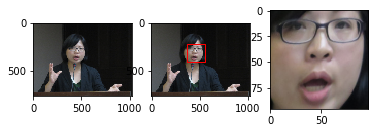

In [58]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

# Initialize the OpenFace face alignment utility
alignment = AlignDlib('models/landmarks.dat')

# Load an image of Jacques Chirac
jc_orig = load_image(metadata[77].image_path())

# Detect face and return bounding box
bb = alignment.getLargestFaceBoundingBox(jc_orig)

# Transform image using specified face landmark indices and crop image to 96x96
jc_aligned = alignment.align(96, jc_orig, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

# Show original image
plt.subplot(131)
plt.imshow(jc_orig)

# Show original image with bounding box
plt.subplot(132)
plt.imshow(jc_orig)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

# Show aligned image
plt.subplot(133)
plt.imshow(jc_aligned);

As described in the OpenFace [pre-trained models](https://cmusatyalab.github.io/openface/models-and-accuracies/#pre-trained-models) section, landmark indices `OUTER_EYES_AND_NOSE` are required for model nn4.small2.v1. Let's implement face detection, transformation and cropping as `align_image` function for later reuse.

In [36]:
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

### Embedding vectors

Embedding vectors can now be calculated by feeding the aligned and scaled images into the pre-trained network.

In [60]:
embedded = np.zeros((metadata.shape[0], 128))

for i, m in enumerate(metadata):
    try:
        img = load_image(m.image_path())
        img = align_image(img)
        img = (img / 255.).astype(np.float32)
        embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]
    # scale RGB values to interval [0,1]
    # obtain embedding vector for image
    except:
        print(m.image_path())

Let's verify on a single triplet example that the squared L2 distance between its anchor-positive pair is smaller than the distance between its anchor-negative pair.

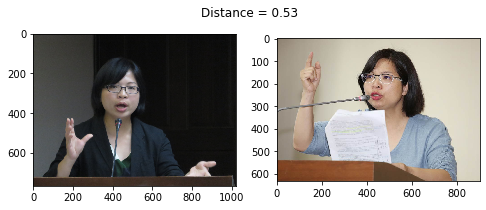

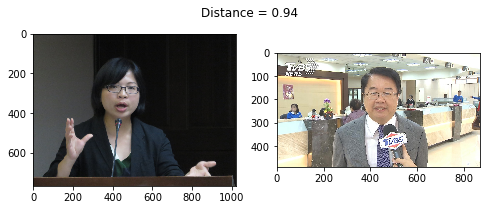

In [61]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(77, 78)
show_pair(77, 150)

As expected, the distance between the two images of Jacques Chirac is smaller than the distance between an image of Jacques Chirac and an image of Gerhard Schröder (0.30 < 1.12). But we still do not know what distance threshold $\tau$ is the best boundary for making a decision between *same identity* and *different identity*.

### Distance threshold

To find the optimal value for $\tau$, the face verification performance must be evaluated on a range of distance threshold values. At a given threshold, all possible embedding vector pairs are classified as either *same identity* or *different identity* and compared to the ground truth. Since we're dealing with skewed classes (much more negative pairs than positive pairs), we use the [F1 score](https://en.wikipedia.org/wiki/F1_score) as evaluation metric instead of [accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html).

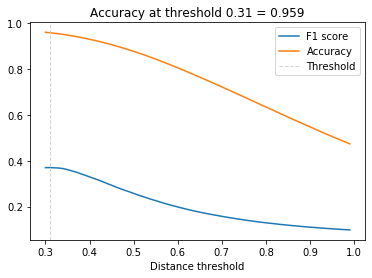

In [62]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)

for i in range(num - 1):
    for j in range(i + 1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

The face verification accuracy at $\tau$ = 0.58 is 95.6%. This is not bad given a baseline of 89% for a classifier that always predicts *different identity* (there are 450 pos. pairs and 4500 neg. pairs) but since nn4.small2.v1 is a relatively small model it is still less than what can be achieved by state-of-the-art models (> 99%). 

The following two histograms show the distance distributions of positive and negative pairs and the location of the decision boundary. There is a clear separation of these distributions which explains the discriminative performance of the network. One can also spot some strong outliers in the positive pairs class but these are not further analyzed here.

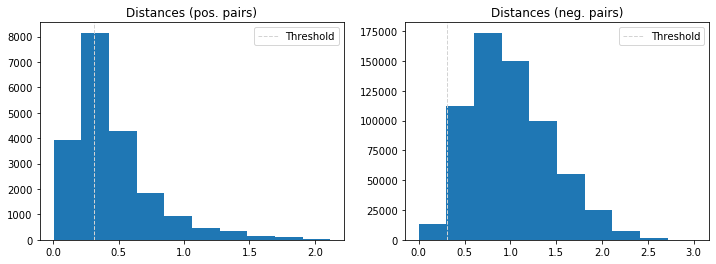

In [63]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (neg. pairs)')
plt.legend();

### Face recognition

Given an estimate of the distance threshold $\tau$, face recognition is now as simple as calculating the distances between an input embedding vector and all embedding vectors in a database. The input is assigned the label (i.e. identity) of the database entry with the smallest distance if it is less than $\tau$ or label *unknown* otherwise. This procedure can also scale to large databases as it can be easily parallelized. It also supports one-shot learning, as adding only a single entry of a new identity might be sufficient to recognize new examples of that identity.

A more robust approach is to label the input using the top $k$ scoring entries in the database which is essentially [KNN classification](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) with a Euclidean distance metric. Alternatively, a linear [support vector machine](https://en.wikipedia.org/wiki/Support_vector_machine) (SVM) can be trained with the database entries and used to classify i.e. identify new inputs. For training these classifiers we use 50% of the dataset, for evaluation the other 50%.

In [64]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

train_idx = np.arange(metadata.shape[0]) % 2 != 0
test_idx = np.arange(metadata.shape[0]) % 2 == 0

# 50 train examples of 10 identities (5 examples each)
X_train = embedded[train_idx]
# 50 test examples of 10 identities (5 examples each)
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))

print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

KNN accuracy = 0.7717770034843205, SVM accuracy = 0.8205574912891986


The KNN classifier achieves an accuracy of 96% on the test set, the SVM classifier 98%. Let's use the SVM classifier to illustrate face recognition on a single example.

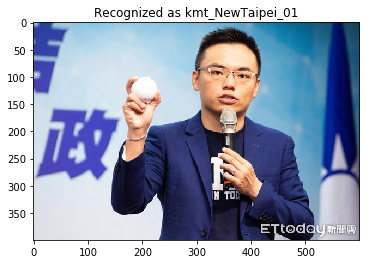

In [72]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 300

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = svc.predict([embedded[test_idx][example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Recognized as {example_identity}');

Seems reasonable :-) Classification results should actually be checked whether (a subset of) the database entries of the predicted identity have a distance less than $\tau$, otherwise one should assign an *unknown* label. This step is skipped here but can be easily added.



### Dataset visualization

To embed the dataset into 2D space for displaying identity clusters, [t-distributed Stochastic Neighbor Embedding](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) (t-SNE) is applied to the 128-dimensional embedding vectors. Except from a few outliers, identity clusters are well separated.

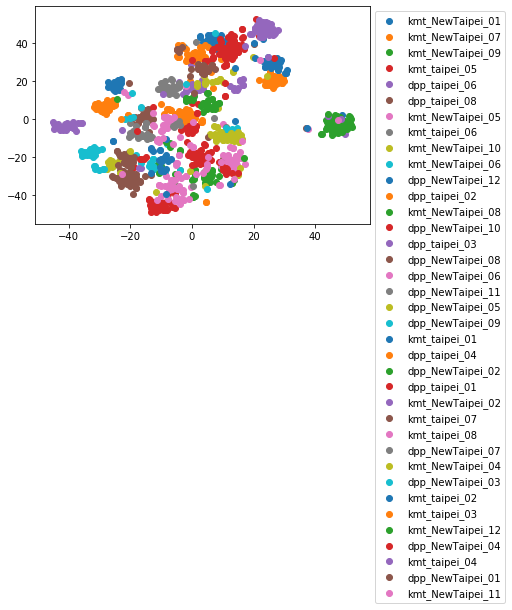

In [79]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embedded)

for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));

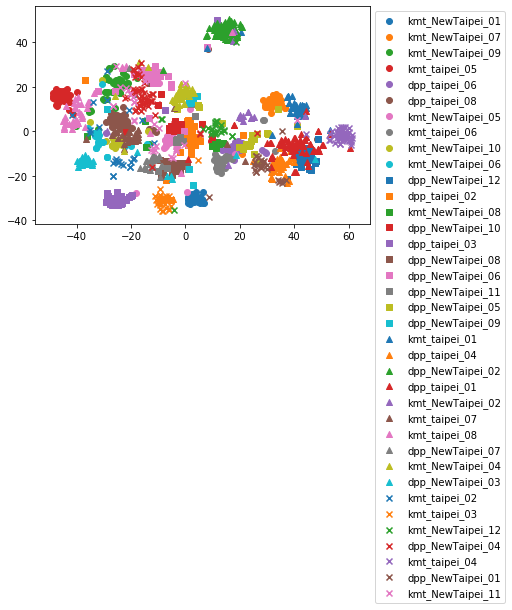

In [97]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2,init='pca',random_state=0).fit_transform(embedded)

for i, t in enumerate(set(targets)):
    idx = targets == t
    if int(i/10)==0:
        plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t,marker="o")
    if int(i/10)==1:
        plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t,marker="s")
    if int(i/10)==2:
        plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t,marker="^")
    if int(i/10)==3:
        plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t,marker="x")
    if int(i/10)==4:
        plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t,marker="+")
    
plt.legend(bbox_to_anchor=(1, 1));

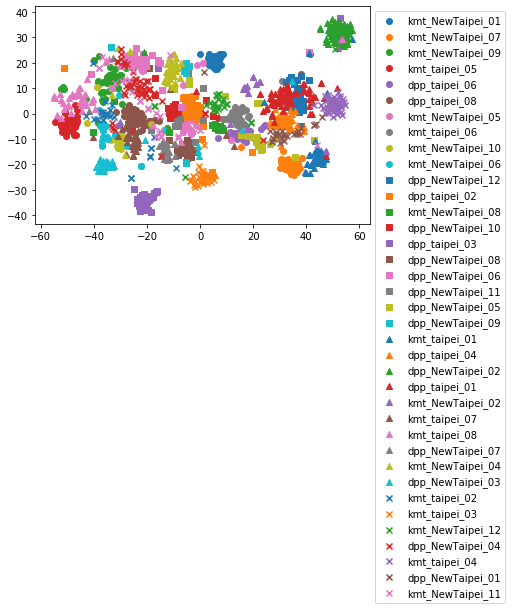

In [109]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2,init='pca',random_state=0,perplexity=50,n_iter=10000,learning_rate=10,method='exact').fit_transform(embedded)

for i, t in enumerate(set(targets)):
    idx = targets == t
    if int(i/10)==0:
        plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t,marker="o")
    if int(i/10)==1:
        plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t,marker="s")
    if int(i/10)==2:
        plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t,marker="^")
    if int(i/10)==3:
        plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t,marker="x")
    if int(i/10)==4:
        plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t,marker="+")
    
plt.legend(bbox_to_anchor=(1, 1));

### References

- [1] [FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/abs/1503.03832)
- [2] [Going Deeper with Convolutions](https://arxiv.org/abs/1409.4842)